# Prediction of absolute developmental potential using CytoTrace2

CytoTRACE 2 is a computational method for predicting cellular potency categories and absolute developmental potential from single-cell RNA-sequencing data.

Potency categories in the context of CytoTRACE 2 classify cells based on their developmental potential, ranging from totipotent and pluripotent cells with broad differentiation potential to lineage-restricted oligopotent, multipotent and unipotent cells capable of producing varying numbers of downstream cell types, and finally, differentiated cells, ranging from mature to terminally differentiated phenotypes.

We made three improvements in integrating the CytoTrace2 algorithm in OmicVerse:

- No additional packages to install, including R
- We fixed a bug in multi-threaded pools to avoid potential error reporting
- Native support for `anndata`, you don't need to export `input_file` and `annotation_file`.

If you found this tutorial helpful, please cite CytoTrace2 and OmicVerse:

Kang, M., Armenteros, J. J. A., Gulati, G. S., Gleyzer, R., Avagyan, S., Brown, E. L., Zhang, W., Usmani, A., Earland, N., Wu, Z., Zou, J., Fields, R. C., Chen, D. Y., Chaudhuri, A. A., & Newman, A. M. (2024). Mapping single-cell developmental potential in health and disease with interpretable deep learning. bioRxiv : the preprint server for biology, 2024.03.19.585637. https://doi.org/10.1101/2024.03.19.585637

In [1]:
import omicverse as ov
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.3, Tutorials: https://omicverse.readthedocs.io/


## Preprocess data

As an example, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

In [2]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 1.5829088687896729 seconds.
End of size normalization: shiftlog and HVGs selection pearson
CPU times: user 2.18 s, sys: 142 ms, total: 2.33 s
Wall time: 1.71 s


AnnData object with n_obs × n_vars = 2930 × 13189
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    var: 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

## Predict cytotrace2

We need to import the two pre-trained models from CytoTrace2, see the download links for the models:

- Figshare:
  https://figshare.com/ndownloader/files/47258749

- or Github:
    https://github.com/digitalcytometry/cytotrace2/tree/main/cytotrace2_python/cytotrace2_py/resources/17_models_weights
    https://github.com/digitalcytometry/cytotrace2/tree/main/cytotrace2_python/cytotrace2_py/resources/5_models_weights

All parameters are explained as follows:
- adata: AnnData object containing the scRNA-seq data.
- use_model_dir: Path to the directory containing the pre-trained model files.
- species: The species of the input data. Default is "mouse".
- batch_size: The number of cells to process in each batch. Default is 10000.
- smooth_batch_size: The number of cells to process in each batch for smoothing. Default is 1000.
- disable_parallelization: If True, disable parallel processing. Default is False.
- max_cores: Maximum number of CPU cores to use for parallel processing. If None, all available cores will be used. Default is None.
- max_pcs: Maximum number of principal components to use. Default is 200.
- seed: Random seed for reproducibility. Default is 14.
- output_dir: Directory to save the results. Default is 'cytotrace2_results'.

In [5]:
results =  ov.single.cytotrace2(adata,
    use_model_dir="cymodels/5_models_weights",
    species="mouse",
    batch_size = 10000,
    smooth_batch_size = 1000,
    disable_parallelization = False,
    max_cores = None,
    max_pcs = 200,
    seed = 14,
    output_dir = 'cytotrace2_results'
)

cytotrace2: Input parameters
    Species: mouse
    Parallelization enabled: True
    User-provided limit for number of cores to use: None
    Batch size: 10000
    Smoothing batch size: 1000
    Max PCs: 200
    Seed: 14
    Output directory: cytotrace2_results
cytotrace2: Dataset characteristics
    Number of input genes:  13189
    Number of input cells:  2930
cytotrace2: The passed batch_size is greater than the number of cells in the subsample. 
    Now setting batch_size to 2930.
cytotrace2: Preprocessing
cytotrace2: 12 cores detected
cytotrace2: Running 1 prediction batch(es) in parallel using 10 cores for smoothing per batch.
cytotrace2: Initiated processing batch 1/1 with 2930 cells
    11276 input genes are present in the model features.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

computing PCA
    with n_comps=200
    finished (0:00:04)
cytotrace2: Results saved to adata.obs           
    CytoTRACE2_Score: CytoTRACE2 score           
    CytoTRACE2_Potency: CytoTRACE2 potency           
    CytoTRACE2_Relative: CytoTRACE2 relative score           
    preKNN_CytoTRACE2_Score: CytoTRACE2 score before kNN smoothing           
    preKNN_CytoTRACE2_Potency: CytoTRACE2 potency before kNN smoothing
cytotrace2: Finished.


## Visualizing

Visualizing the results we can directly compare the predicted potency scores with the known developmental stage of the cells, seeing how the predictions meticulously align with the known biology. Take a look!

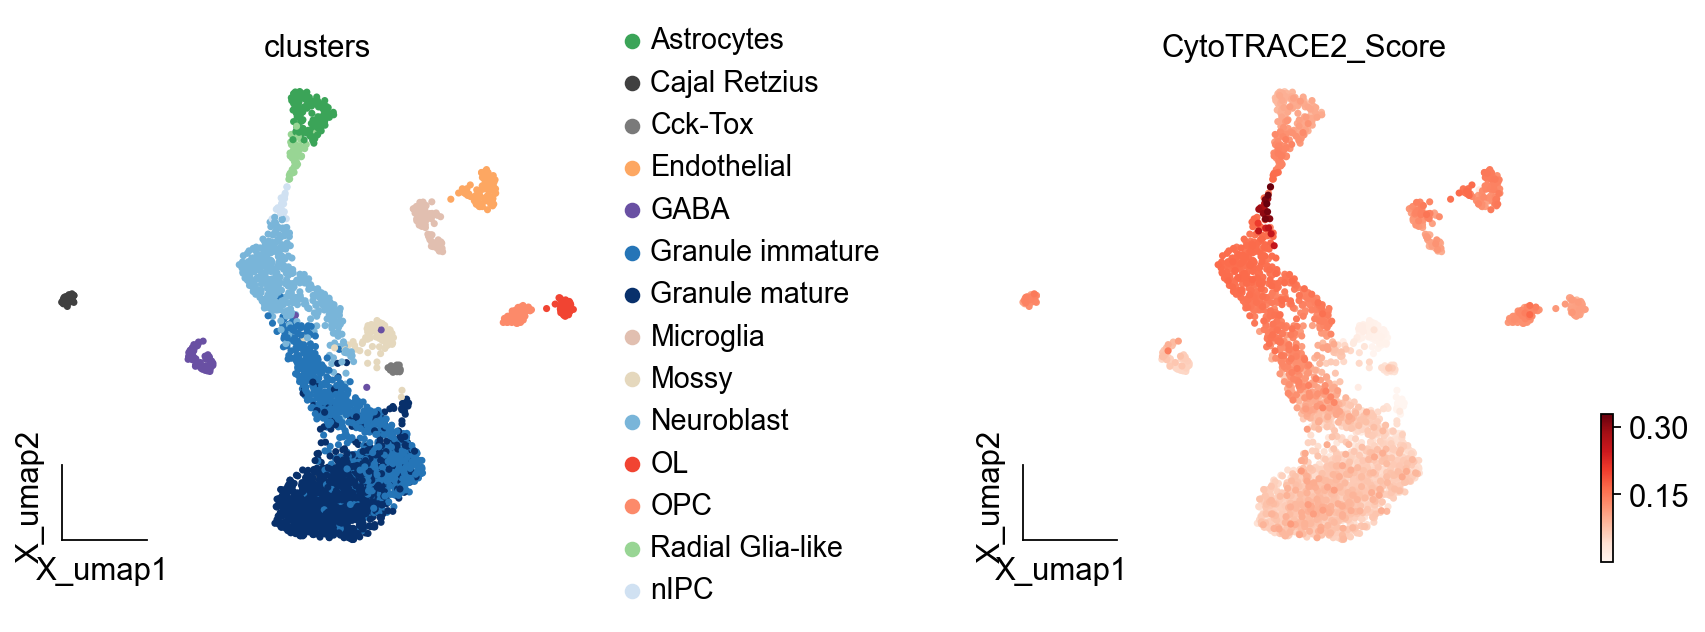

In [8]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','CytoTRACE2_Score'],
                   frameon='small',cmap='Reds',wspace=0.55)

- Left: demonstrates the distribution of different cell types in UMAP space.
- Right: demonstrates the CytoTRACE 2 scores of different cell types; cells with high scores are generally considered to have a higher pluripotency or undifferentiated state.

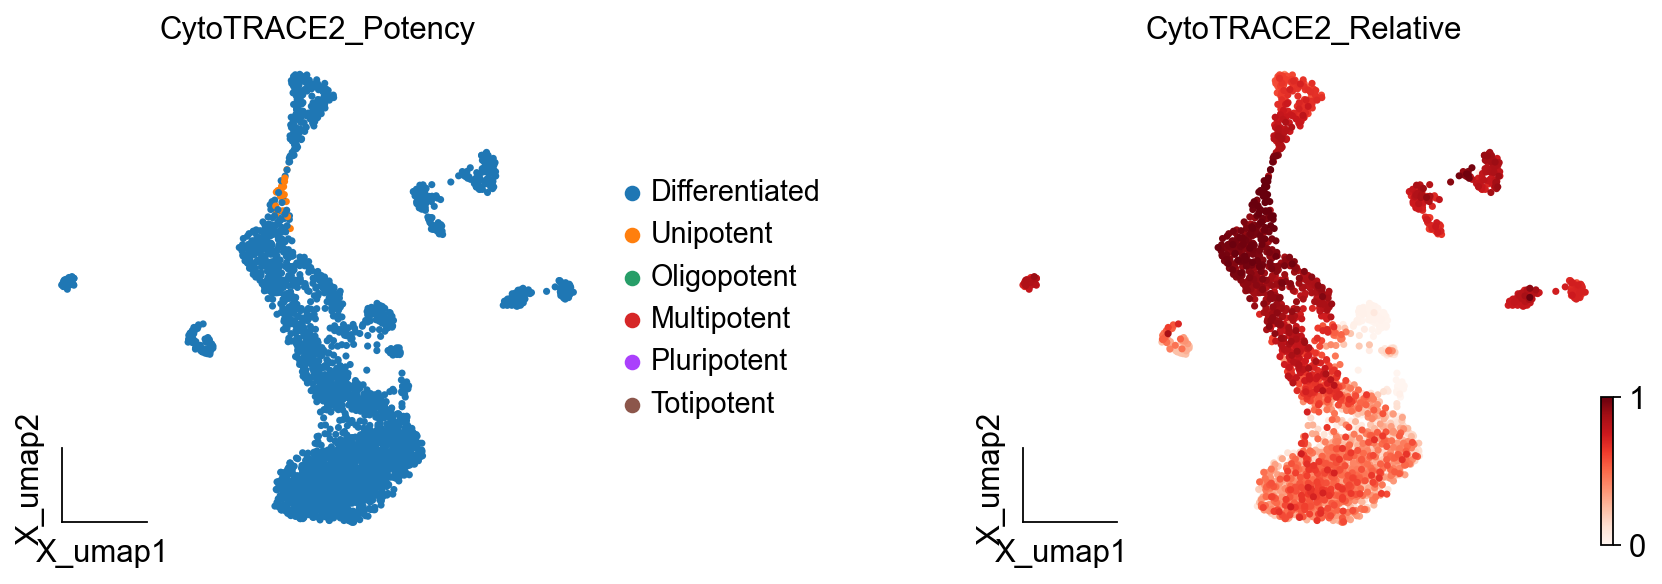

In [9]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['CytoTRACE2_Potency','CytoTRACE2_Relative'],
                   frameon='small',cmap='Reds',wspace=0.55)

- Potency category:
    The UMAP embedding plot of predicted potency category reflects the discrete classification of cells into potency categories, taking possible values of Differentiated, Unipotent, Oligopotent, Multipotent, Pluripotent, and Totipotent.
- Relative order:
    UMAP embedding of predicted relative order, which is based on absolute predicted potency scores normalized to the range 0 (more differentiated) to 1 (less differentiated). Provides the relative ordering of cells by developmental potential